In [ ]:
 !pip install datasets


  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import numpy as np
import os
from datasets import Dataset
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os

def load_data(base_dir, layer='layer_10_processed'):
    embeddings = []
    labels = []
    label_map = {}
    current_label = 0

    for speaker_dir in os.listdir(base_dir):
        layer_dir = os.path.join(base_dir, speaker_dir, layer)
        speaker_embeddings = []

        if os.path.isdir(layer_dir):
            for file_name in os.listdir(layer_dir):
                if file_name.endswith('.npy'):
                    path = os.path.join(layer_dir, file_name)
                    embedding = np.load(path)
                    speaker_embeddings.append(embedding)

            # Append each embedding separately to the main list
            for emb in speaker_embeddings:
                embeddings.append(emb)
                # Check if the speaker has a label assigned, if not assign one
                if speaker_dir not in label_map:
                    label_map[speaker_dir] = current_label
                    current_label += 1
                # Append the label corresponding to the speaker for each embedding
                labels.append(label_map[speaker_dir])

    # Convert list of embeddings and labels to numpy arrays for further processing
    embeddings = np.array(embeddings)
    labels = np.array(labels)
    return embeddings, labels

# Example usage
base_dir = '/content/drive/My Drive/NLP/clips__test/'
embeddings, labels = load_data(base_dir)


In [ ]:
# Reshape data if necessary (assuming each .npy file contains data in a form that can be input directly into a CNN)
# Example: reshaping to fit a simple CNN expecting inputs of shape (height, width, channels)
# embeddings = embeddings.reshape(embeddings.shape[0], height, width, channels)

# Encode labels to one-hot vectors
labels = to_categorical(labels)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(embeddings, labels, test_size=0.1, random_state=42)


In [ ]:
embeddings.shape

(12958, 1, 100, 1024)

In [ ]:

X_train = X_train.reshape(-1, 100, 1024, 1)  # Assuming your data is in (batch_size, 1, 100, 1024)
X_val = X_val.reshape(-1, 100, 1024, 1)


In [ ]:
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Example adjustment: reshape your data appropriately before using this function
# Make sure `X_train` is reshaped if necessary
# input_shape = (height, width, channels)
input_shape = (100, 1024, 1)  # Now it matches the reshaped data
num_classes = y_val.shape[1]
model = build_model(input_shape, num_classes)




20

In [ ]:
from tensorflow.keras import models, layers
from sklearn.metrics import f1_score, classification_report
import numpy as np

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=10,
                    validation_data=(X_val, y_val))

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Calculate F1 score
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"F1 Score: {f1}")
print(classification_report(y_true_classes, y_pred_classes))


Epoch 1/20
1167/1167 [==============================] - 42s 32ms/step - loss: 1.6868 - accuracy: 0.4997 - val_loss: 0.4522 - val_accuracy: 0.8418
Epoch 2/20
1167/1167 [==============================] - 35s 30ms/step - loss: 0.2957 - accuracy: 0.8886 - val_loss: 0.3979 - val_accuracy: 0.8542
Epoch 3/20
1167/1167 [==============================] - 36s 31ms/step - loss: 0.1688 - accuracy: 0.9326 - val_loss: 0.4092 - val_accuracy: 0.8588
Epoch 4/20
1167/1167 [==============================] - 36s 31ms/step - loss: 0.1414 - accuracy: 0.9442 - val_loss: 0.3217 - val_accuracy: 0.8765
Epoch 5/20
1167/1167 [==============================] - 36s 31ms/step - loss: 0.1068 - accuracy: 0.9600 - val_loss: 0.3538 - val_accuracy: 0.8781
Epoch 6/20
1167/1167 [==============================] - 36s 31ms/step - loss: 0.0997 - accuracy: 0.9633 - val_loss: 0.5343 - val_accuracy: 0.8619
Epoch 7/20
1167/1167 [==============================] - 36s 31ms/step - loss: 0.0711 - accuracy: 0.9744 - val_loss: 0.4079 -

In [ ]:
model.save('/content/drive/My Drive/NLP/models/layer_0_model.keras')

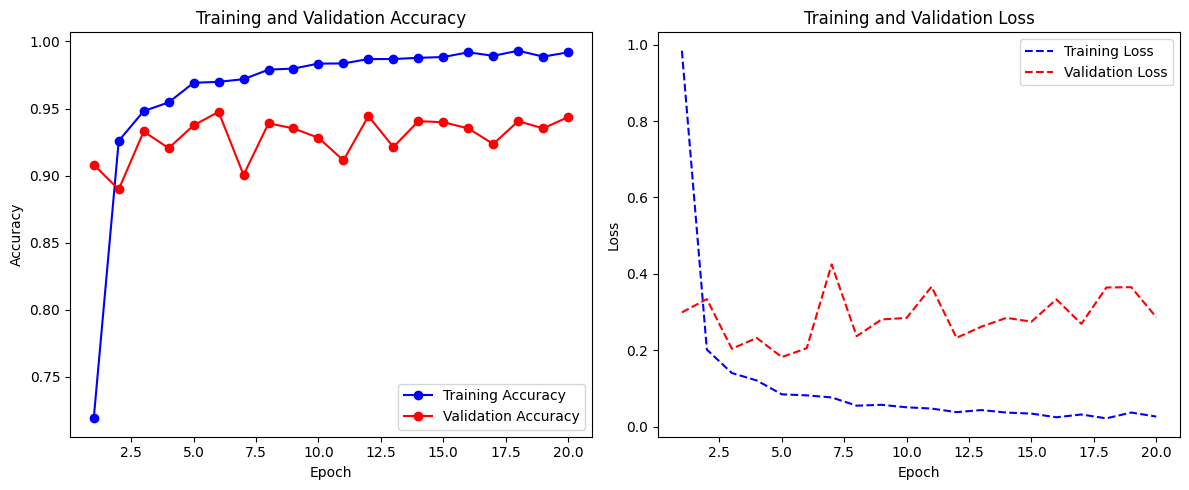

In [ ]:
import matplotlib.pyplot as plt

# Data from the epochs
epochs = list(range(1, 21))
train_accuracy = [
    0.7191, 0.9259, 0.9481, 0.9546, 0.9692, 0.9699, 0.9719, 0.9790,
    0.9798, 0.9835, 0.9836, 0.9869, 0.9869, 0.9878, 0.9884, 0.9919,
    0.9893, 0.9931, 0.9887, 0.9919
]
val_accuracy = [
    0.9082, 0.8897, 0.9329, 0.9205, 0.9375, 0.9475, 0.9005, 0.9390,
    0.9352, 0.9282, 0.9113, 0.9444, 0.9213, 0.9406, 0.9398, 0.9352,
    0.9236, 0.9406, 0.9352, 0.9437
]
train_loss = [
    0.9843, 0.2018, 0.1404, 0.1208, 0.0846, 0.0819, 0.0764, 0.0549,
    0.0571, 0.0506, 0.0473, 0.0379, 0.0434, 0.0368, 0.0341, 0.0245,
    0.0318, 0.0217, 0.0369, 0.0263
]
val_loss = [
    0.2991, 0.3339, 0.2040, 0.2322, 0.1821, 0.2053, 0.4248, 0.2368,
    0.2807, 0.2846, 0.3664, 0.2325, 0.2619, 0.2848, 0.2748, 0.3332,
    0.2691, 0.3643, 0.3651, 0.2863
]

plt.figure(figsize=(12, 5))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b--', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Load a saved model
loaded_model = load_model('/content/drive/My Drive/NLP/models/layer_0_model.keras')

In [ ]:

import pandas as pd

# Convert the history dictionary to a pandas DataFrame
metrics_df = pd.DataFrame(loaded_model.history)

# Display the DataFrame
print(metrics_df)


Empty DataFrame
Columns: []
Index: []


In [ ]:
!pip install numba

In [ ]:


from numba import cuda
device = cuda.get_current_device()
device.reset()